In [1150]:
import os
import gcm_filters
import cmocean
import matplotlib

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from skimage.measure import find_contours
from scipy.interpolate import splprep, splev
from shapely.geometry import Polygon, Point


datadir = "../data/"
figdir = "../figures/"

In [1151]:
def get_region_coords(region_name="arctic_ocean", xy=False):
    region_dict = {
        "arctic_ocean": {False: [-180, 180, 60, 90], True: [65, 185, 0, 215]},
        "canada_basin": {False: [-180, -95, 70, 85], True: [70, 130, 135, 205]},
        "amerasian_basin": {False: [], True: [70, 160, 120, 205]},
        "eurasian_basin": {False: [-180, 180, 78, 90], True: [110, 180, 80, 170]},
        "makarov_basin": {False: [-180, 180, 78, 90], True: [110, 155, 120, 190]},
        "greenland_basin": {False: [-15, 15, 72, 80], True: [110, 145, 50, 85]},
        "lofoten_basin": {False: [-5, 13.5, 68, 73], True: [125, 145, 30, 55]},
        "norwegian_basin": {False: [-8, 3, 63, 71], True: [115, 135, 15, 45]},
        "norwegian_seas": {False: [-15, 15, 62, 73], True: [115, 155, 10, 55]},
        "nordic_seas": {False: [-15, 15, 62, 73], True: [75, 175, 0, 90]},
    }
    
    if region_name not in region_dict:
        raise ValueError("Undefined region, please check spelling.")
    
    return region_dict[region_name][xy]

In [1152]:
ds = xr.open_dataset(datadir + "bathymetry_with_gradients_filter50_ease.nc")
ds

<xarray.Dataset> Size: 3MB
Dimensions:  (y: 264, x: 264)
Coordinates:
    lat      (y, x) float32 279kB ...
    lon      (y, x) float32 279kB ...
  * x        (x) int64 2kB 0 1 2 3 4 5 6 7 8 ... 256 257 258 259 260 261 262 263
  * y        (y) int64 2kB 0 1 2 3 4 5 6 7 8 ... 256 257 258 259 260 261 262 263
Data variables:
    depth    (y, x) float64 558kB ...
    dhdx     (y, x) float64 558kB ...
    dhdy     (y, x) float64 558kB ...
    slope    (y, x) float64 558kB ...

In [1153]:
ds["depth"] = ds.depth/np.sin(np.deg2rad(ds.lat))
ds

<xarray.Dataset> Size: 3MB
Dimensions:  (y: 264, x: 264)
Coordinates:
    lat      (y, x) float32 279kB 47.33 47.5 47.67 47.84 ... 47.67 47.5 47.33
    lon      (y, x) float32 279kB ...
  * x        (x) int64 2kB 0 1 2 3 4 5 6 7 8 ... 256 257 258 259 260 261 262 263
  * y        (y) int64 2kB 0 1 2 3 4 5 6 7 8 ... 256 257 258 259 260 261 262 263
Data variables:
    depth    (y, x) float64 558kB nan nan nan nan nan ... nan nan nan nan nan
    dhdx     (y, x) float64 558kB ...
    dhdy     (y, x) float64 558kB ...
    slope    (y, x) float64 558kB ...

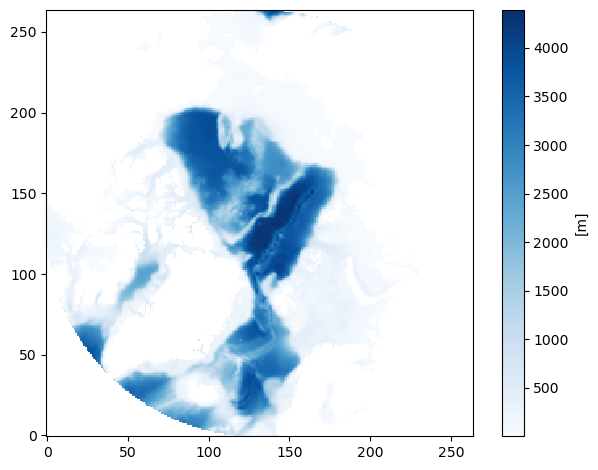

In [1155]:
fig, ax = plt.subplots()

cb = ax.pcolormesh(ds.x, ds.y, ds.depth, cmap="Blues")

fig.colorbar(cb, ax=ax, label="[m]")
ax.set_aspect("equal")
#ax.set_xlim(155, 205)
#ax.set_ylim(50, 105)

fig.tight_layout()

In [1156]:
ds["dx"] = xr.DataArray(
                        np.ones((len(ds.x), len(ds.y)))*25e3,
                        dims=["y", "x"]
                        )
ds["dy"] = xr.DataArray(
                        np.ones((len(ds.x), len(ds.y)))*25e3,
                        dims=["y", "x"]
                        )

In [2007]:
region_name = "norwegian_basin"
region = get_region_coords(region_name, xy=True)
region

[115, 135, 15, 45]

In [2008]:
ds_sel = ds.sel(x=slice(region[0], region[1]),
                y=slice(region[2], region[3])
               )
ds_sel

<xarray.Dataset> Size: 37kB
Dimensions:  (y: 31, x: 21)
Coordinates:
    lat      (y, x) float32 3kB 63.41 63.44 63.47 63.5 ... 70.54 70.53 70.52
    lon      (y, x) float32 3kB ...
  * x        (x) int64 168B 115 116 117 118 119 120 ... 130 131 132 133 134 135
  * y        (y) int64 248B 15 16 17 18 19 20 21 22 ... 38 39 40 41 42 43 44 45
Data variables:
    depth    (y, x) float64 5kB 822.1 1.103e+03 ... 3.348e+03 3.377e+03
    dhdx     (y, x) float64 5kB ...
    dhdy     (y, x) float64 5kB ...
    slope    (y, x) float64 5kB ...
    dx       (y, x) float64 5kB 2.5e+04 2.5e+04 2.5e+04 ... 2.5e+04 2.5e+04
    dy       (y, x) float64 5kB 2.5e+04 2.5e+04 2.5e+04 ... 2.5e+04 2.5e+04

In [2193]:
# Set initial parameters for the contour and filter configurations
contour_name, contour_foverH, contour_depth = region_name, 4.4e-8, 3950

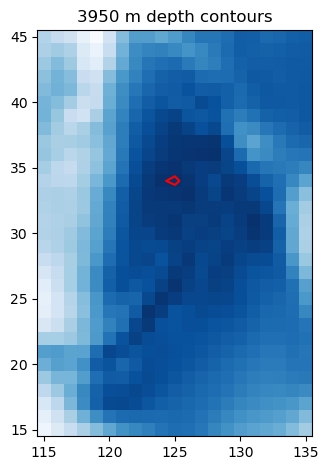

In [2194]:
# Plot filtered contours
#fig, ax = create_map(region_name, region)
fig, ax = plt.subplots()

cb = ax.pcolormesh(ds_sel.x,
                   ds_sel.y,
                   ds_sel.depth,
                   cmap="Blues"
                  )

ax.contour(ds_sel.x,
           ds_sel.y,
           ds_sel.depth,
           levels=[contour_depth],
           colors="red"
          )

#fig.colorbar(cb, ax=ax, label="[m]")
ax.set_aspect("equal")

ax.set_title(f"{contour_depth} m depth contours")

#fig.supxlabel("xi-index")
#fig.supylabel("eta-index")

fig.tight_layout()

In [2180]:
breakpoint = 0
skippoints = []

contours = find_contours(ds_sel.depth.values,
                         level=contour_depth,
                         fully_connected="high"
                        )
contours.sort(key=len)
contours.reverse()
print(np.shape(contours[0]))
contour_list = []
for n, contour in enumerate(contours):
    if n > breakpoint:
        break
    if n in skippoints:
        continue
    for coord in contour:
        contour_list.append(coord)
contour_array = np.array(contour_list)
print(np.shape(contour_array))

contour_array = contour_array[:, ::-1]
contour_array[:, 0] += region[0]
contour_array[:, 1] += region[2]

# Convert the contour coordinates to a closed polygon
polygon = Polygon(contour_array)

# Create a mesh grid for coordinates
X, Y = np.meshgrid(ds_sel.x, ds_sel.y)

# Function to create a mask from the polygon
def create_mask(X, Y, polygon):
    mask = np.zeros(X.shape, dtype=bool)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            mask[i, j] = polygon.contains(Point(X[i, j], Y[i, j]))
    return mask

# Apply the mask creation function
mask = create_mask(X, Y, polygon)
mask_da = xr.DataArray(mask, dims=["y", "x"], coords=dict(x=ds_sel.x, y=ds_sel.y)).assign_coords(depth=contour_depth).expand_dims("depth")
mask_da.attrs["h_value"] = contour_depth
mask_da.attrs["region"] = region
mask_da.attrs["region_name"] = region_name
mask_da.attrs["description"] = region_name + " contour mask"
mask_da.name = "contour_mask"
mask_da

(23, 2)
(23, 2)


<xarray.DataArray 'contour_mask' (depth: 1, y: 31, x: 21)> Size: 651B
array([[[False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
...
         False, False, False, False, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False],
        [False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False]]])
Coordinates:
  * x        (x) int64 168B 115 116 117 118 119 120 ... 130 131 132 133 134 135
  * y        (y) int64 248B 15 16 17 18 19 20 21 22 ... 38 39 40 41 42 43 44 45
  * depth    (depth) int64 8B 3900
Attributes:
    h_value:      3900
    region:       [115, 135, 15, 45]
    region_name:  norwegian_basin
    description:  norwegian_basin contour mask

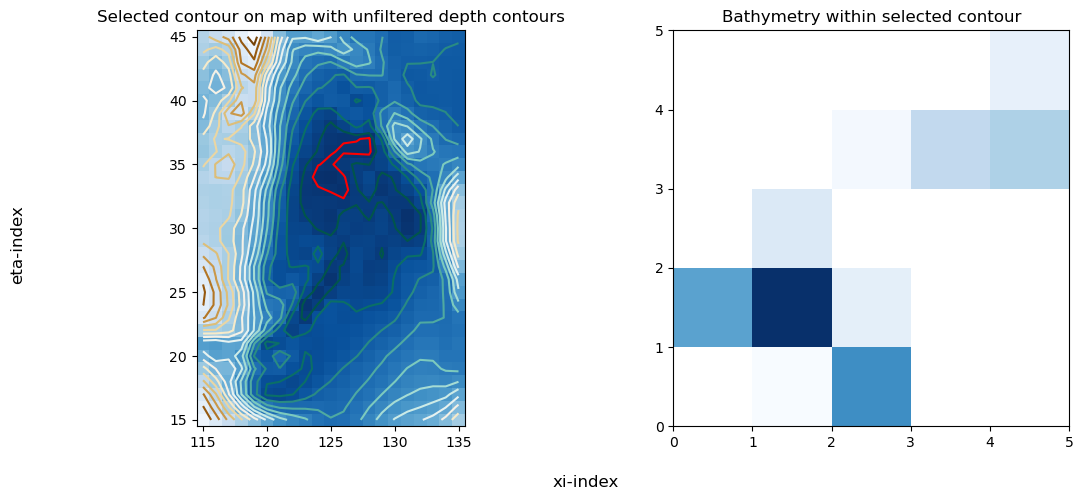

In [2181]:
# Extract the bathymetry within the mask
hc = ds_sel.depth.where(mask_da.isel(depth=0).drop_vars("depth"), drop=True)

# Plot the mask and extracted bathymetry
fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(12, 5))
ax1.pcolormesh(ds_sel.x, ds_sel.y, ds_sel.depth, cmap="Blues")
ax1.contour(ds_sel.x, ds_sel.y, ds_sel.depth, zorder=10, cmap="BrBG", levels=20)
ax1.plot(contour_array[:, 0], contour_array[:, 1], color="red", zorder=20)
ax2.pcolormesh(hc, cmap="Blues")

ax1.set_title("Selected contour on map with unfiltered depth contours")
ax2.set_title("Bathymetry within selected contour")

fig.supxlabel("xi-index")
fig.supylabel("eta-index")

ax1.set_aspect("equal")
ax2.set_aspect("equal")

fig.tight_layout()

In [2182]:
mask_da.to_netcdf(datadir + region_name + "/contourmask_eff_" + str(mask_da.h_value) + ".nc")

In [2183]:
# Identify boundary cells for horizontal and vertical edges
mask_left = np.roll(mask, shift=1, axis=1)
mask_right = np.roll(mask, shift=-1, axis=1)
mask_up = np.roll(mask, shift=1, axis=0)
mask_down = np.roll(mask, shift=-1, axis=0)

# Determine boundary masks
horizontal_boundary_mask = (mask & (~mask_left | ~mask_right))
vertical_boundary_mask = (mask & (~mask_up | ~mask_down))

# Select edge lengths
dx_edge = ds_sel.dx
dy_edge = ds_sel.dy

# Calculate horizontal and vertical boundary lengths
horizontal_edge_lengths = dx_edge.where(horizontal_boundary_mask, 0)
vertical_edge_lengths = dy_edge.where(vertical_boundary_mask, 0)

# Sum to get total circumference
circumference = (horizontal_edge_lengths.sum() + vertical_edge_lengths.sum()).values
mask_da["L"] = circumference

In [2184]:
# Create tangential vectors along the contour
contourx = contour_array[:, 0] 
contoury = contour_array[:, 1]
tx = contourx[1:] - contourx[:-1]
ty = contoury[1:] - contoury[:-1]
dist = np.sqrt(tx**2 + ty**2)

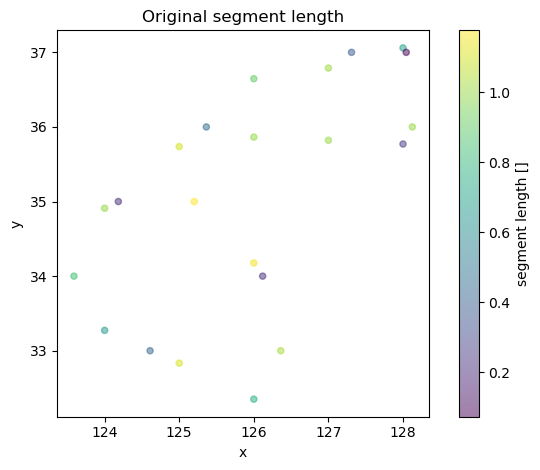

In [2185]:
# Plot length of each contour segment
fig, ax = plt.subplots()
x = np.arange(len(dist))
s = ax.scatter(contourx[:-1], contoury[:-1], c=dist, cmap="viridis", alpha=0.5, s=20)
fig.colorbar(s, label="segment length []")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_aspect("equal")

ax.set_title("Original segment length")
fig.tight_layout()

In [2186]:
### Adjust contour segments to be of equal length

# Fit spline to contour data
tck, u = splprep([contour_array[:, 0], contour_array[:, 1]], s=0.1)

# Evaluate spline on evenly spaced interval
num_points = len(dist)
new_u = np.linspace(0, 1, num_points)
new_points = splev(new_u, tck)

# %%
# Re-calculate tangential vectors 
contourx = new_points[0]
contoury = new_points[1]
tx = contourx[1:] - contourx[:-1]
ty = contoury[1:] - contoury[:-1]
dist = np.sqrt(tx**2 + ty**2)
np.mean(dist)

np.float64(0.7709865769040547)

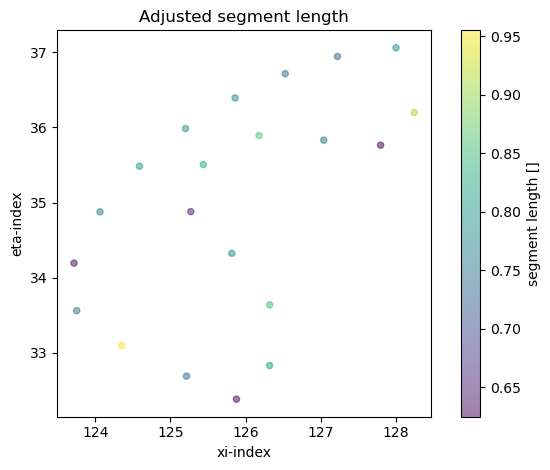

In [2187]:
# Plot new tangential vectors
fig, ax = plt.subplots()
x = np.arange(len(dist))
s = ax.scatter(contourx[:-1], contoury[:-1], c=dist, cmap="viridis", alpha=0.5, s=20)
fig.colorbar(s, label="segment length []")
ax.set_xlabel("xi-index")
ax.set_ylabel("eta-index")
ax.set_aspect("equal")

ax.set_title("Adjusted segment length")
fig.tight_layout()

In [2188]:
# Normalize tangents and adjust direction based on contour type
tx = tx / dist
ty = ty / dist

In [2189]:
# Create an xarray dataset for tangential vectors
dsc = xr.Dataset(
    data_vars=dict(
        tx=(["point"], tx),
        ty=(["point"], ty),
    ),
    coords=dict(
        point=np.arange(len(tx)),
        x=("point", contourx[:-1]),
        y=("point", contoury[:-1])
    ),
    attrs=dict(description=f"Tangent {contour_name} contour."),
)

# Add contour type attribute
#dsc.name = "contour"
dsc.attrs["h_value"] = contour_depth
dsc.attrs["region_name"] = region_name
dsc.attrs["region"] = region
dsc

<xarray.Dataset> Size: 840B
Dimensions:  (point: 21)
Coordinates:
  * point    (point) int64 168B 0 1 2 3 4 5 6 7 8 ... 12 13 14 15 16 17 18 19 20
    x        (point) float64 168B 128.0 127.2 126.5 125.9 ... 127.0 127.8 128.2
    y        (point) float64 168B 37.06 36.95 36.72 36.39 ... 35.83 35.76 36.2
Data variables:
    tx       (point) float64 168B -0.9894 -0.9497 -0.9004 ... 0.7166 -0.285
    ty       (point) float64 168B -0.1451 -0.313 -0.435 ... 0.6975 0.9585
Attributes:
    description:  Tangent norwegian_basin contour.
    h_value:      3900
    region_name:  norwegian_basin
    region:       [115, 135, 15, 45]

In [2190]:
# Calculate metric distance using grid spacings
dxc, dyc = ds_sel.dx.interp(x=dsc.x, y=dsc.y), ds_sel.dy.interp(x=dsc.x, y=dsc.y)
metricdist = np.sqrt((dist * dxc * dsc.tx)**2 + (dist * dyc * dsc.ty)**2)
dsc["distance"] = ("point", metricdist.values)

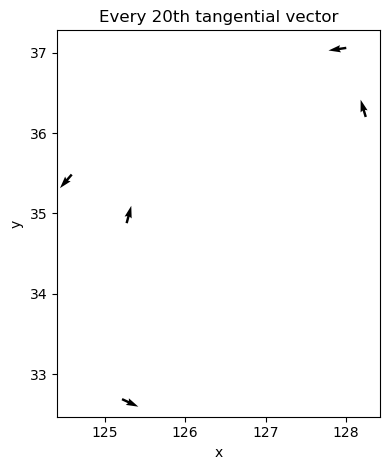

In [2191]:
# Visualize direction of tangential vectors
fig, ax = plt.subplots()
dscs = dsc.isel(point=slice(None, None, 5))
ax.quiver(dscs.x, dscs.y, dscs.tx, dscs.ty)
ax.set_aspect("equal")
ax.set_xlabel("x")
ax.set_ylabel("y")

ax.set_title("Every 20th tangential vector")
fig.tight_layout()

In [2192]:
dsc.to_netcdf(datadir + region_name + "/contour_eff_" + str(mask_da.h_value) + ".nc")